In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

In [12]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,            # base font size
    "axes.labelsize": 16,       # x/y labels
    "axes.titlesize": 17,       # title
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "figure.dpi": 300
})

plt.figure(figsize=(8, 5))

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

In [13]:
def normalize_the_data(flare_data):
    flare_data = np.array(flare_data)
    n_elements = flare_data.shape[0]
    for j in range(flare_data.shape[1]):
        standard_deviation_of_this_feature = np.std(flare_data[:, j])
        median_of_this_feature = np.median(flare_data[:, j])
        for i in range(n_elements):
            flare_data[i, j] = (
                flare_data[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
    return flare_data


In [14]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

## CME association vs Time for 2024 data (Incorrect Normalisation)

In [15]:
TSS_mean_i = []
TSS_std_i = []

for i in range(4,52,4):
  positive = pd.read_csv(f"Data 2024/positive{i}.csv")
  negative = pd.read_csv(f"Data 2024/negative{i}.csv")

  positive = positive.drop(["Unnamed: 0","HARPNUM","NOAA","Class","Peak Time"],axis =1)
  negative = negative.drop(["Unnamed: 0","HARPNUM","NOAA","Class","Peak Time"],axis =1)

  positive = normalize_the_data(positive)
  negative = normalize_the_data(negative)

  data = pd.concat([pd.DataFrame(positive),pd.DataFrame(negative)],axis =0,ignore_index=True)
  xdata = np.array(data)
  ydata = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])), axis=0)

  number_of_examples = data.shape[0]
  C = 4.0
  gamma = 0.075
  class_weight = "balanced"
  clf = SVC(C=C, gamma=gamma, kernel='rbf', class_weight=class_weight,cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)

  skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
  these_TSS_for_this_k = []
  for train_index, test_index in skf.split(xdata, ydata):
      # xtrain are the examples in the training set
      xtrain = xdata[train_index]
      # ytrain are the labels in the training set
      ytrain = ydata[train_index]
      # xtest are the examples in the testing set
      xtest = xdata[test_index]
      ytest = ydata[test_index]    # ytest are the labels in the testing set
      clf.fit(xtrain, ytrain)
      TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
      if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
          these_TSS_for_this_k.append(np.nan)
          continue
      else:
          these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
  TSS_k = np.array(these_TSS_for_this_k)
  TSS_mean_i.append(np.mean(TSS_k))
  TSS_std_i.append(np.std(TSS_k))
  print(f"The TSS for timedelta {i} is: {np.mean(TSS_k):0.2f} ± {np.std(TSS_k):0.2f}")

The TSS for timedelta 4 is: 0.63 ± 0.08
The TSS for timedelta 8 is: 0.51 ± 0.10
The TSS for timedelta 12 is: 0.50 ± 0.05
The TSS for timedelta 16 is: 0.54 ± 0.07
The TSS for timedelta 20 is: 0.41 ± 0.12
The TSS for timedelta 24 is: 0.62 ± 0.06
The TSS for timedelta 28 is: 0.66 ± 0.09
The TSS for timedelta 32 is: 0.63 ± 0.09
The TSS for timedelta 36 is: 0.62 ± 0.05
The TSS for timedelta 40 is: 0.55 ± 0.08
The TSS for timedelta 44 is: 0.62 ± 0.10
The TSS for timedelta 48 is: 0.60 ± 0.08


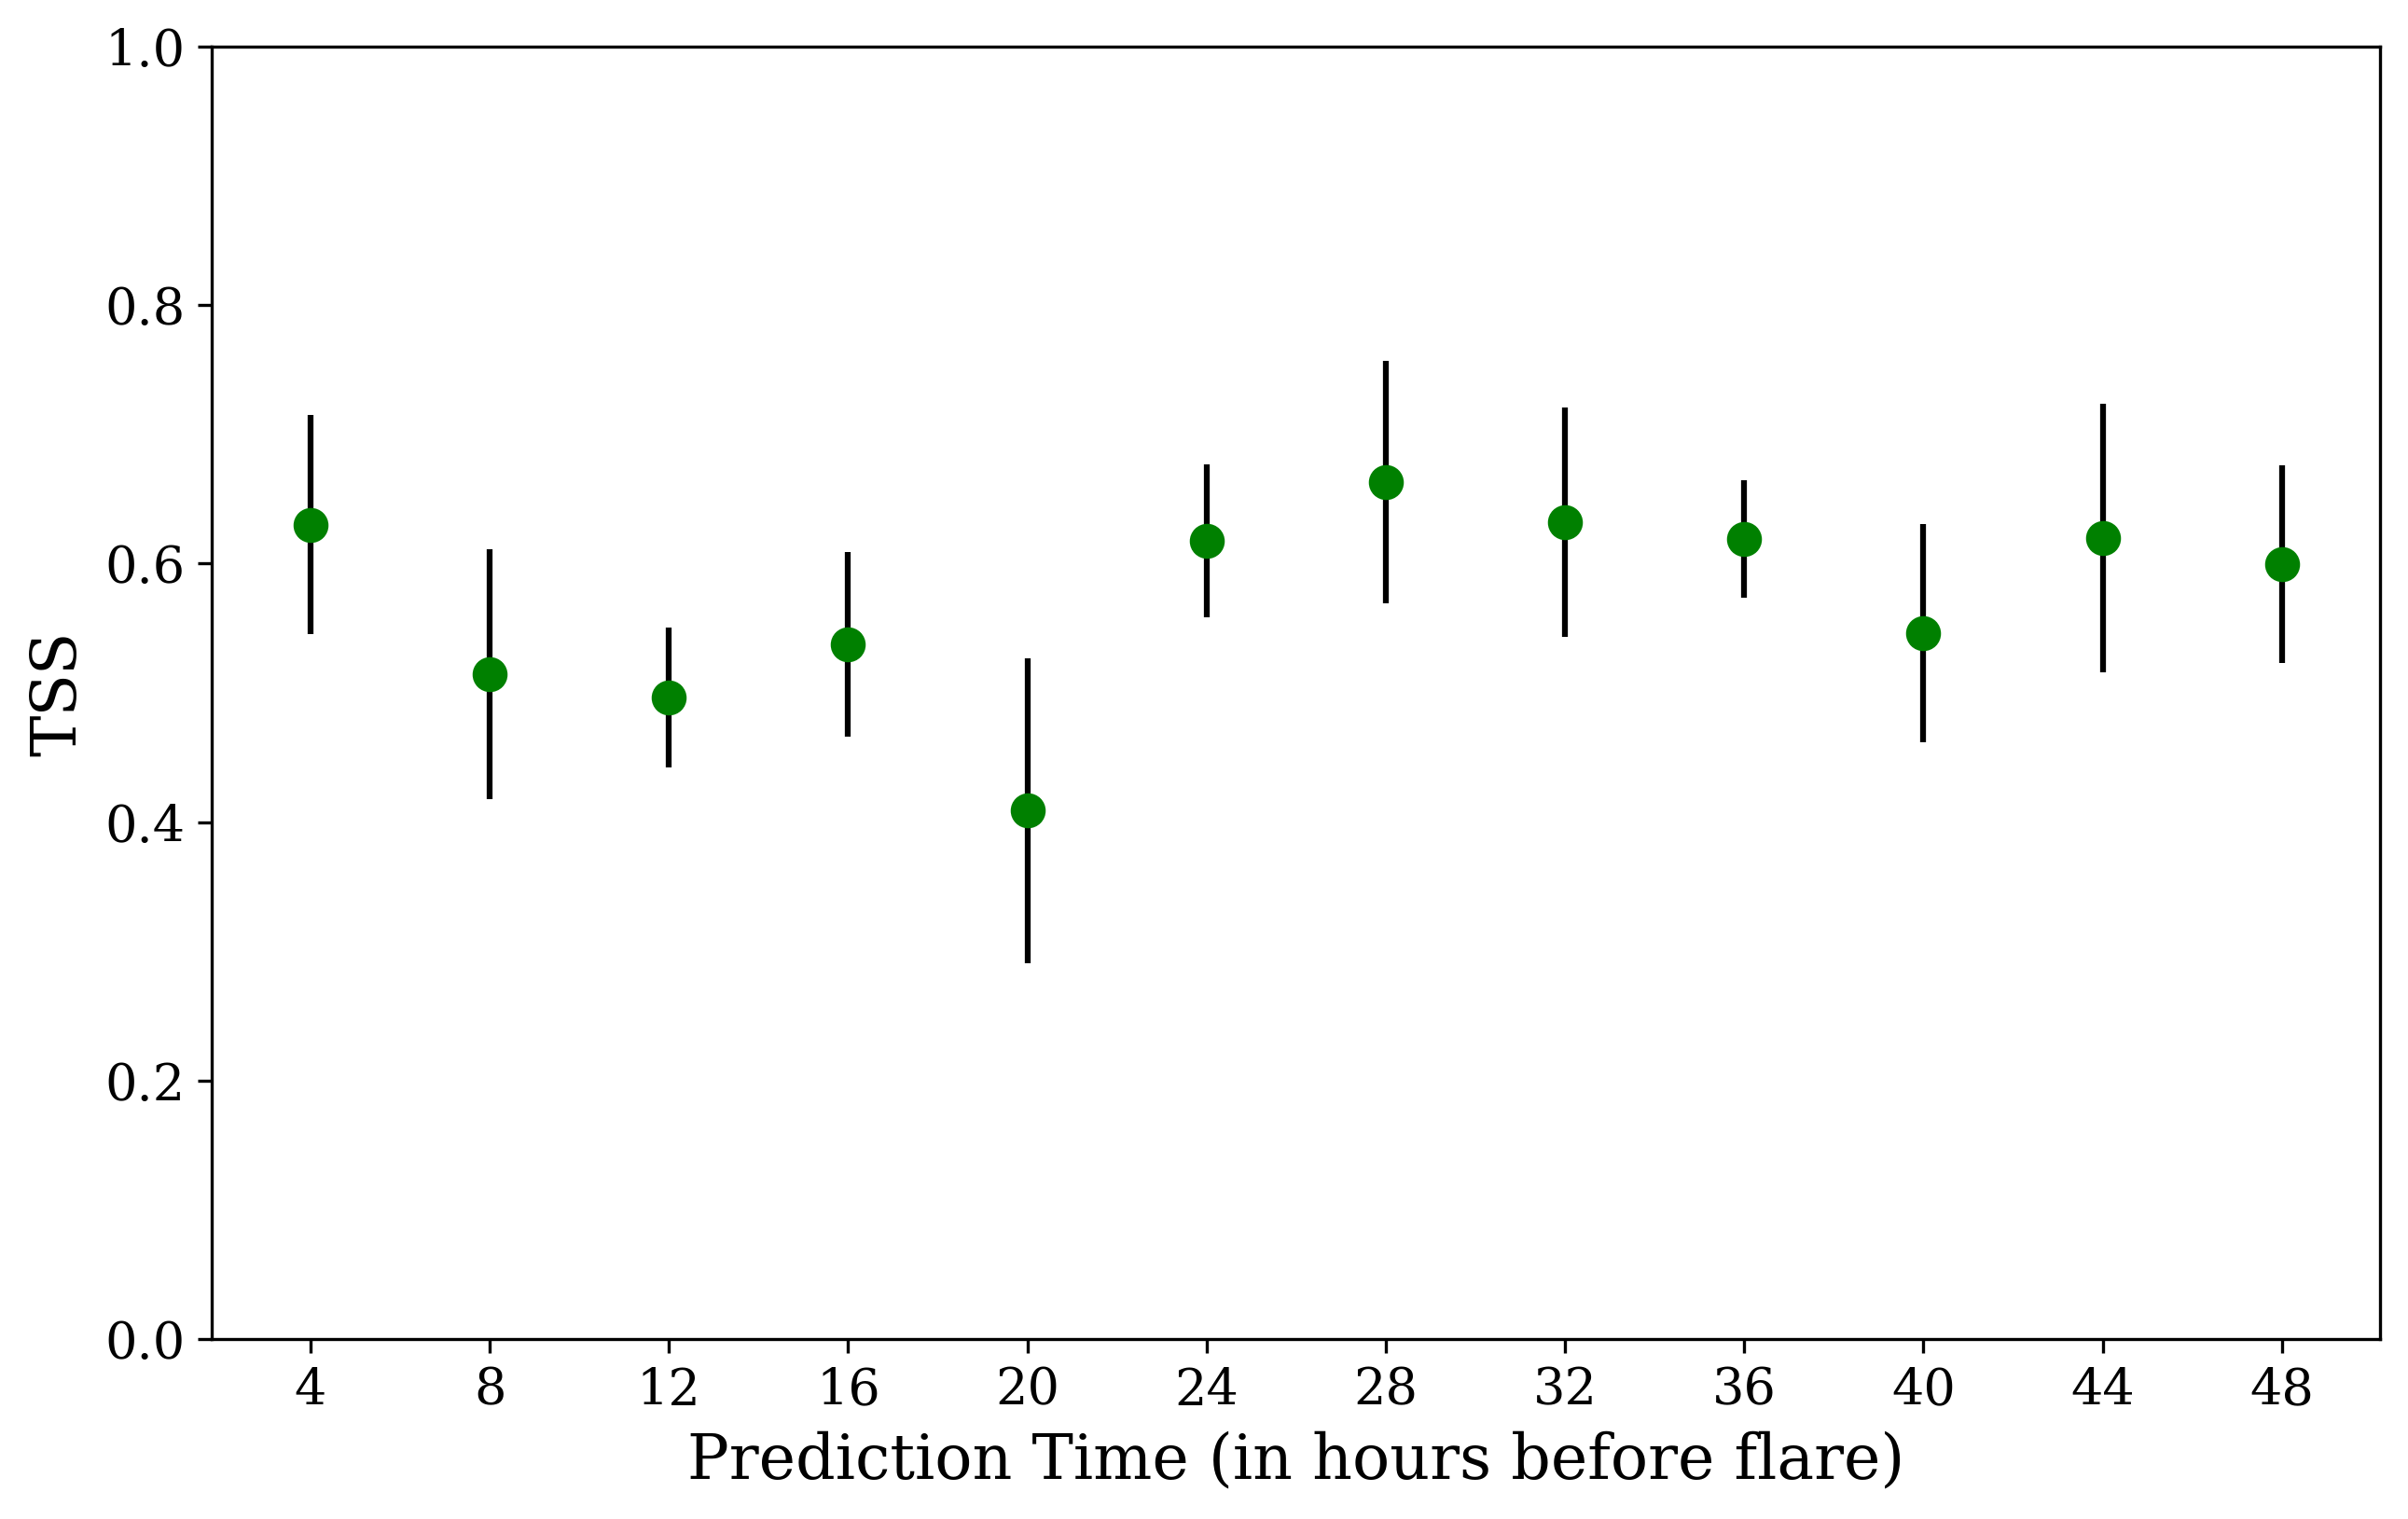

In [16]:
time_delta = range(4, 52, 4)

plt.figure(figsize=(10, 6), dpi=300)
plt.errorbar(time_delta, TSS_mean_i, yerr=TSS_std_i, fmt='o', c='black', markerfacecolor='green', markeredgecolor='green', markersize=8)
plt.xticks(time_delta)
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xlabel('Prediction Time (in hours before flare)')
plt.ylabel('TSS')
plt.show()

## CME association vs Time for 2024 data (Correct Normalisation)

In [17]:
TSS_mean_c = []
TSS_std_c = []

for i in range(4,52,4):
  positive = pd.read_csv(f"Data 2024/positive{i}.csv")
  negative = pd.read_csv(f"Data 2024/negative{i}.csv")

  positive = positive.drop(["Unnamed: 0","HARPNUM","NOAA","Class","Peak Time"],axis =1)
  negative = negative.drop(["Unnamed: 0","HARPNUM","NOAA","Class","Peak Time"],axis =1)

  data = pd.concat([pd.DataFrame(positive),pd.DataFrame(negative)],axis =0,ignore_index=True)

  xdata = normalize_the_data(data)
  ydata = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])), axis=0)

  number_of_examples = data.shape[0]
  C = 4.0
  gamma = 0.075
  class_weight = "balanced"
  clf = SVC(C=C, gamma=gamma, kernel='rbf', class_weight=class_weight,cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)

  skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
  these_TSS_for_this_k = []
  for train_index, test_index in skf.split(xdata, ydata):
      # xtrain are the examples in the training set
      xtrain = xdata[train_index]
      # ytrain are the labels in the training set
      ytrain = ydata[train_index]
      # xtest are the examples in the testing set
      xtest = xdata[test_index]
      ytest = ydata[test_index]    # ytest are the labels in the testing set
      clf.fit(xtrain, ytrain)
      TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
      if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
          these_TSS_for_this_k.append(np.nan)
          continue
      else:
          these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
  TSS_k = np.array(these_TSS_for_this_k)
  TSS_mean_c.append(np.mean(TSS_k))
  TSS_std_c.append(np.std(TSS_k))
  print(f"The TSS for timedelta {i} is: {np.mean(TSS_k):0.2f} ± {np.std(TSS_k):0.2f}")

The TSS for timedelta 4 is: 0.28 ± 0.11
The TSS for timedelta 8 is: 0.25 ± 0.12
The TSS for timedelta 12 is: 0.20 ± 0.09
The TSS for timedelta 16 is: 0.28 ± 0.05
The TSS for timedelta 20 is: 0.24 ± 0.09
The TSS for timedelta 24 is: 0.25 ± 0.11
The TSS for timedelta 28 is: 0.20 ± 0.10
The TSS for timedelta 32 is: 0.28 ± 0.07
The TSS for timedelta 36 is: 0.24 ± 0.10
The TSS for timedelta 40 is: 0.31 ± 0.07
The TSS for timedelta 44 is: 0.27 ± 0.05
The TSS for timedelta 48 is: 0.25 ± 0.07


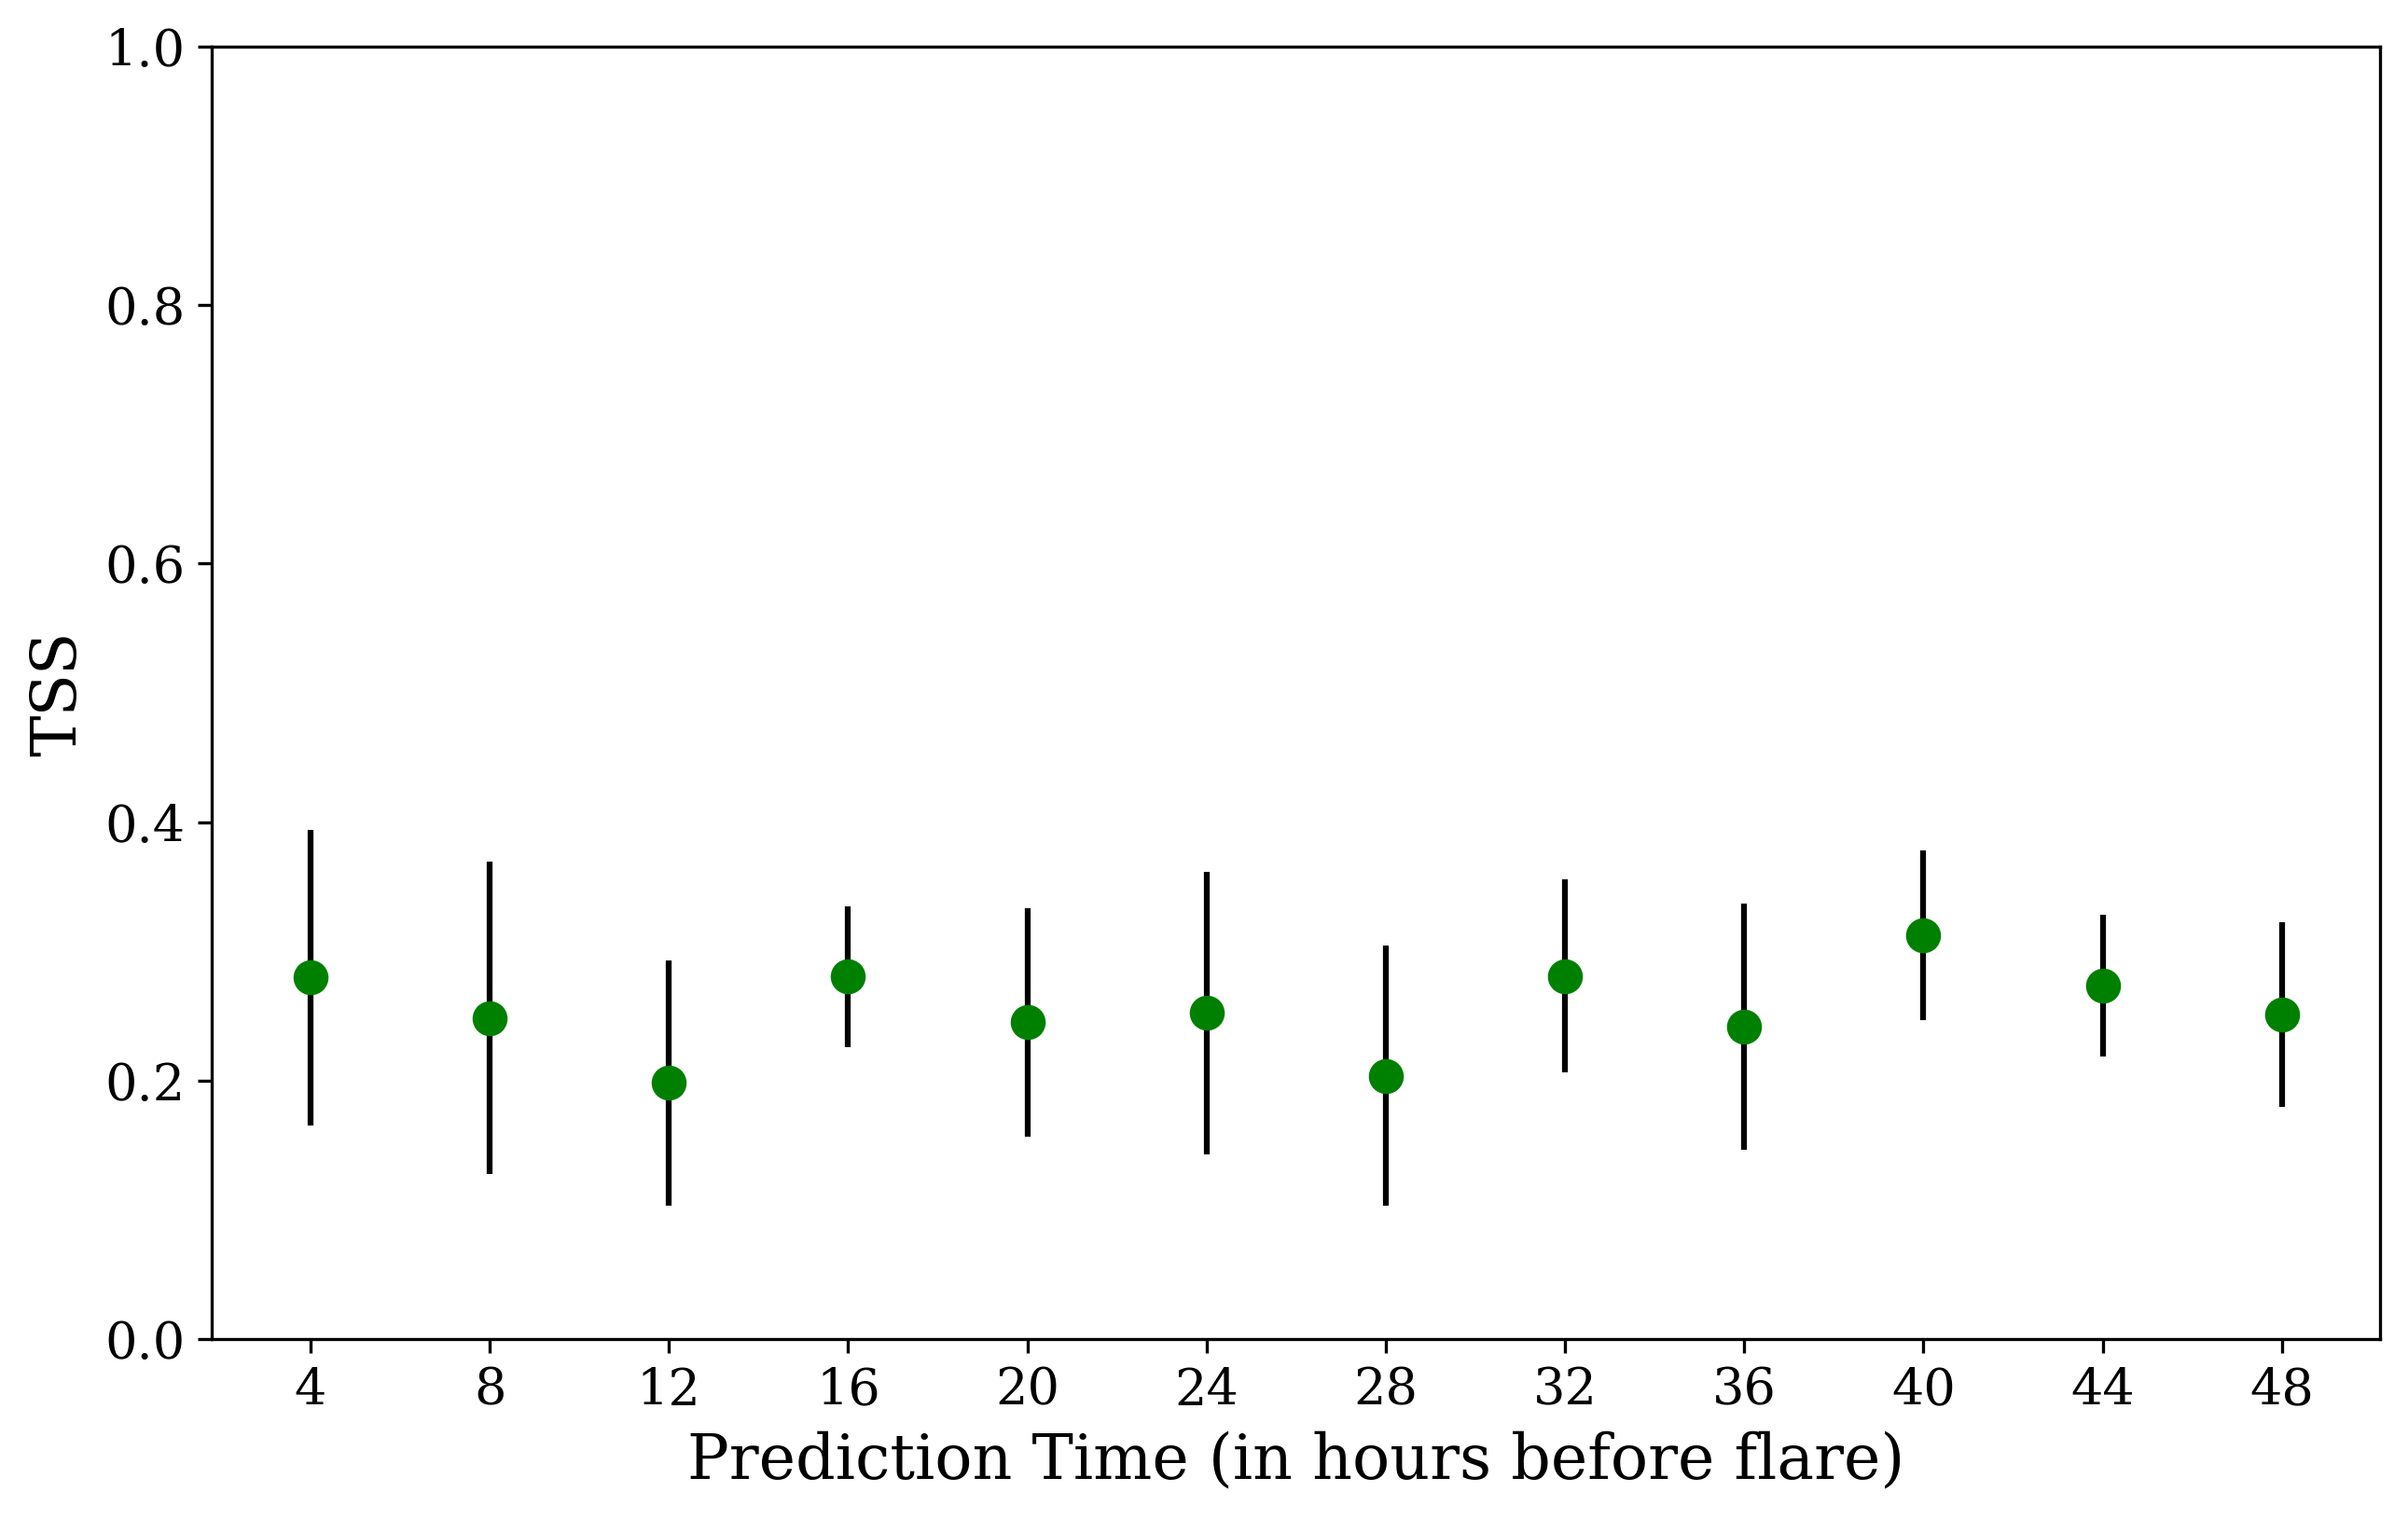

: 

In [ ]:
time_delta = range(4, 52, 4)

plt.figure(figsize=(10, 6), dpi=300)
plt.errorbar(time_delta, TSS_mean_c, yerr=TSS_std_c, fmt='o', c='black', markerfacecolor='green', markeredgecolor='green', markersize=8)
plt.xticks(time_delta)
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xlabel('Prediction Time (in hours before flare)')
plt.ylabel('TSS')
plt.show()